<a href="https://colab.research.google.com/github/jamagiwa/Kaggle/blob/Explore_und_practice/GBM_scRNAseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GBM scRNAseqデータを用いてEDAの練習する

What: scRNAseqデータを用いて解析の手法を学ぶ

---

Why: 遺伝子発現、epigenome、proteomeデータを自由に扱えるようになりたいため

---

Result


##データの読み込み、データフレームを作成

使うライブラリ

In [130]:
#Colaboにanndataをダウンロード
!pip install anndata scanpy
!pip install leidenalg
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00


In [120]:
import kagglehub
import scipy.io
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
#データのダウンロード
!pip install kagglehub


# Download latest version
path = kagglehub.dataset_download("reminho/human-glioblastoma-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-glioblastoma-dataset


In [91]:
#ファイル名の確認
import os
print(os.listdir(path))

['barcodes.tsv', 'matrix.mtx', 'genes.tsv']


barcodes.tsv...各細胞のID, matrix.mtx...実際の遺伝子発現data(ほとんどのgeneが0なので特殊な形式で効率よく保存している。), genes.tsv...遺伝子名のリスト

3つのファイルを読み込む

In [92]:
#ファイルパスを設定
path = "/kaggle/input/human-glioblastoma-dataset"
barcodes_file = f"{path}/barcodes.tsv"
gene_file = f"{path}/genes.tsv"
matrix_file = f"{path}/matrix.mtx"

print(matrix_file)

/kaggle/input/human-glioblastoma-dataset/matrix.mtx


##QC, ノイズ除去

In [93]:
# ----------------- 遺伝子リストを正しく読み込む -----------------
# sep='\t'でタブ区切りを指定し、2列目（遺伝子名）をインデックスとして読み込む
genes_df = pd.read_csv(gene_file, header=None, sep='\t')

# ----------------- AnnDataオブジェクトを作成 -----------------
adata = ad.AnnData(
    X=scipy.io.mmread(matrix_file).T.tocsr(),
    obs=pd.read_csv(barcodes_file, header=None, sep='\t', names=['cell_barcode']),
    var=pd.DataFrame(index=genes_df.iloc[:, 1].values)
)

# ----------------- 遺伝子情報（ID、Gene Expressionなど）をadata.varに保存 -----------------
adata.var['gene_id'] = genes_df.iloc[:, 0].values
adata.var['feature_type'] = genes_df.iloc[:, 2].values

# ----------------- 確認 -----------------
print(adata.var)

                gene_id     feature_type
GNB1    ENSG00000078369  Gene Expression
TP73    ENSG00000078900  Gene Expression
PARK7   ENSG00000116288  Gene Expression
TARDBP  ENSG00000120948  Gene Expression
MTOR    ENSG00000198793  Gene Expression
...                 ...              ...
MECP2   ENSG00000169057  Gene Expression
FLNA    ENSG00000196924  Gene Expression
TAZ     ENSG00000102125  Gene Expression
RAB39B  ENSG00000155961  Gene Expression
SRY     ENSG00000184895  Gene Expression

[1186 rows x 2 columns]


/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [95]:
#anndataのコピーを作成、元データの保護
adata_fil = adata.copy()

#遺伝子のフィルタリング
#少なくとも3つの細胞で発現している遺伝子を残す
#pp...pre-processing
sc.pp.filter_genes(adata_fil, min_cells=3)

#少なくとも200の細胞で発現している遺伝子を残す
sc.pp.filter_cells(adata_fil, min_genes=200)

print(f"元の細胞数{adata.n_obs}, 遺伝子数{adata.n_vars}")
print(f"フィルタリング後の細胞数{adata_fil.n_obs}, 遺伝子数{adata_fil.n_vars}")

元の細胞数5697, 遺伝子数1186
フィルタリング後の細胞数4433, 遺伝子数1140


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


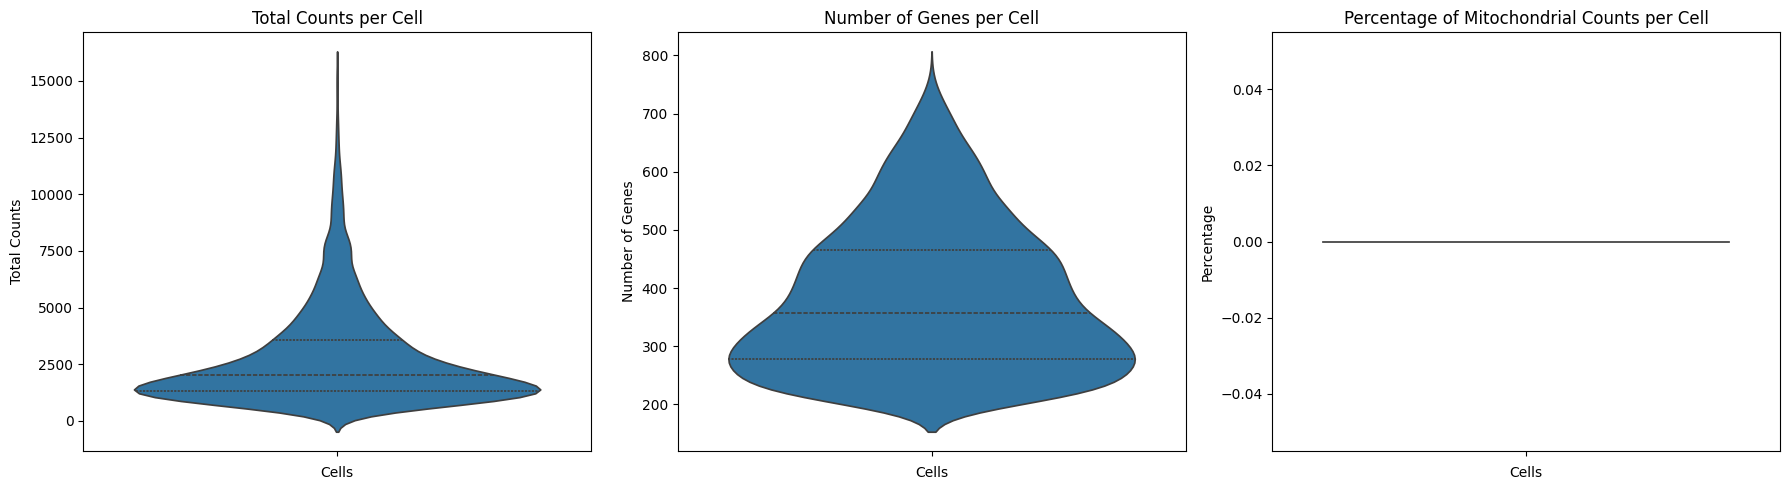

In [99]:
#ミトコンドリア遺伝子を識別する
#"MT"で始まる遺伝子を探す
adata_fil.var['MT'] = adata_fil.var['gene_id'].str.startswith("MT-")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# QCメトリクスを計算
sc.pp.calculate_qc_metrics(adata_fil, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

# バイオリンプロット1: 総読取数
sns.violinplot(y='total_counts', data=adata_fil.obs, ax=axes[0], inner='quartile')
axes[0].set_title('Total Counts per Cell')
axes[0].set_xlabel('Cells')
axes[0].set_ylabel('Total Counts')

# バイオリンプロット2: 発現遺伝子数
sns.violinplot(y='n_genes_by_counts', data=adata_fil.obs, ax=axes[1], inner='quartile')
axes[1].set_title('Number of Genes per Cell')
axes[1].set_xlabel('Cells')
axes[1].set_ylabel('Number of Genes')

# バイオリンプロット3: ミトコンドリア遺伝子の割合
sns.violinplot(y='pct_counts_MT', data=adata_fil.obs, ax=axes[2], inner='quartile')
axes[2].set_title('Percentage of Mitochondrial Counts per Cell')
axes[2].set_xlabel('Cells')
axes[2].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

MTが０なのはなぜかと思ったらすでに取り除いてくれている

In [100]:
True_count = sum(adata_fil.var["MT"])
print(f"Trueの数{True_count}")

False_count = sum(~adata_fil.var["MT"])
print(f"Falesの数{False_count}")


Trueの数0
Falesの数1140


#Normalization, 次元削減

Lognormalizeで行う。一般的な方法らしい。細胞数で割った後に対数変換する

---

対数変換...正規分布に近似、外れ値の影響の軽減、線形性の確保、スケールの収縮

In [101]:
#正規化
#遺伝子発現データの合計が10000になるようにスケーリング、対数変換を行う。
#ノーマライズの値は多くの文献で行われる10000でおこなう。
sc.pp.normalize_total(adata_fil, target_sum=1e4)

#対数変換を行う(log(x+1))
sc.pp.log1p(adata_fil)

次元削減を行う

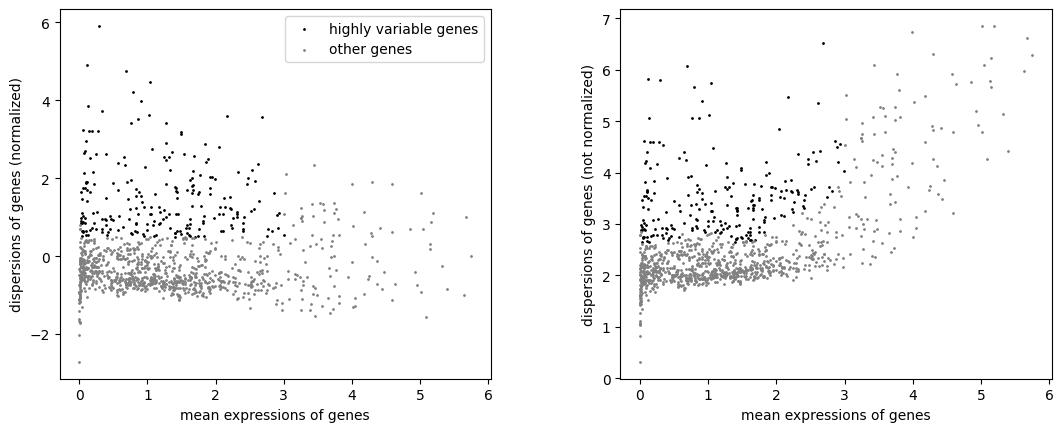

In [102]:
#σが大きい細胞を特定する
#min_mian...平均発現量が0.0125を排除、ノイズの除去, max_mean...発現量が平均３以上を排除, min_disp 分散の最小値
sc.pp.highly_variable_genes(adata_fil, min_mean=0.0125, max_mean=3.0, min_disp=0.5)
sc.pl.highly_variable_genes(adata_fil)

発現量が大きい遺伝子は、サンプリングノイズが入り分散が大きくなる傾向がある。
発現量は少ないが、分散が高い遺伝子→少数の細胞で発現している（生物学的意味のある細胞）を特定するために行う。

##次元削減

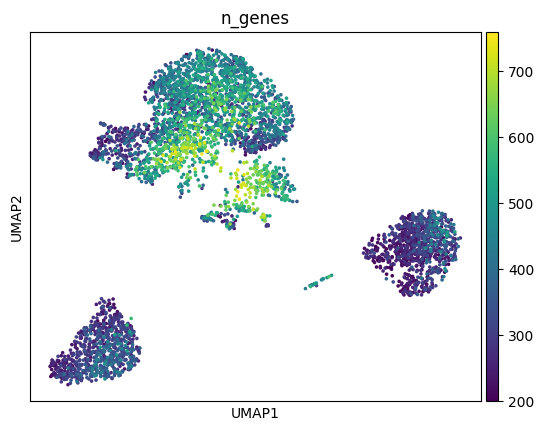

In [103]:
#PCAを行う
#50次元に落とし込む
sc.pp.pca(adata_fil, n_comps=50)

# 近傍グラフを計算
#dim(PCA)だとまだ次元数が大きい。高次元の距離を2~3次元に落とし込むアルゴリズム
#近さの計算を行う。
sc.pp.neighbors(adata_fil, n_neighbors=10, n_pcs=40)

#UMAP
sc.tl.umap(adata_fil)
sc.pl.umap(adata_fil, color = "n_genes")

200~700...対数変換後の遺伝子発現量

##細胞の同定、マーカー探索

In [105]:
print(adata_fil.var_names)

Index(['GNB1', 'TP73', 'PARK7', 'TARDBP', 'MTOR', 'MTHFR', 'CLCN6', 'NPPB',
       'MFN2', 'TNFRSF1B',
       ...
       'XIAP', 'SLC9A6', 'FMR1', 'ATP2B3', 'PLXNB3', 'L1CAM', 'MECP2', 'FLNA',
       'TAZ', 'RAB39B'],
      dtype='object', length=1140)


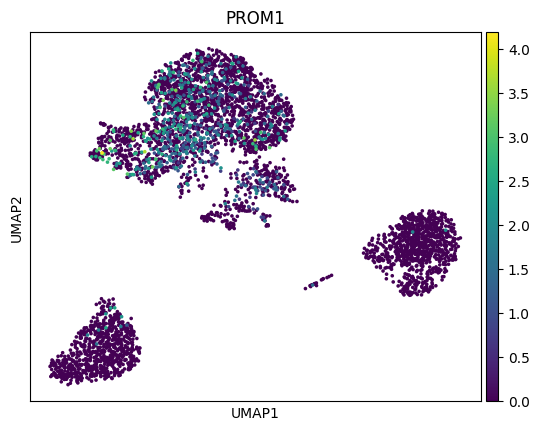

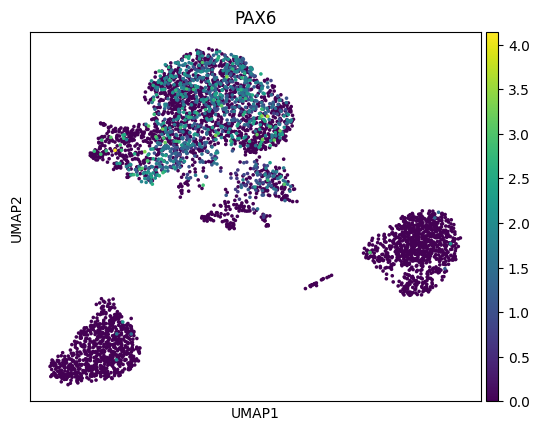

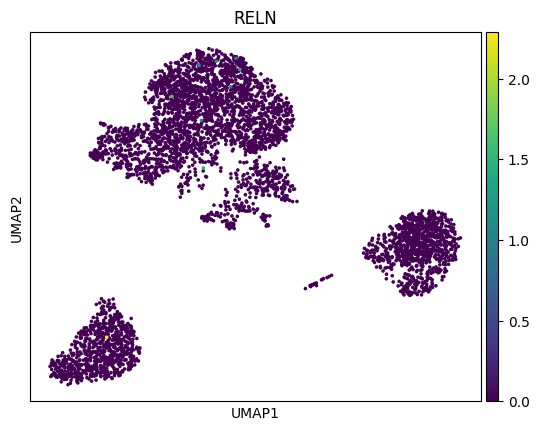

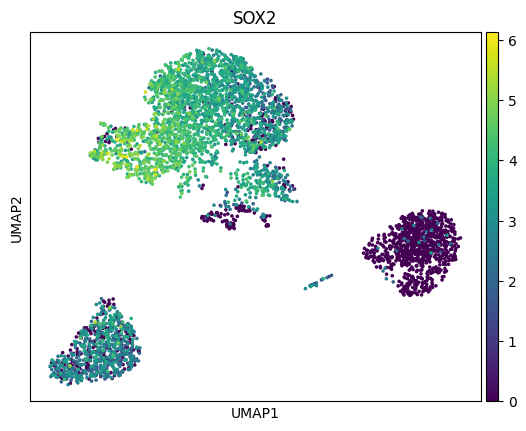

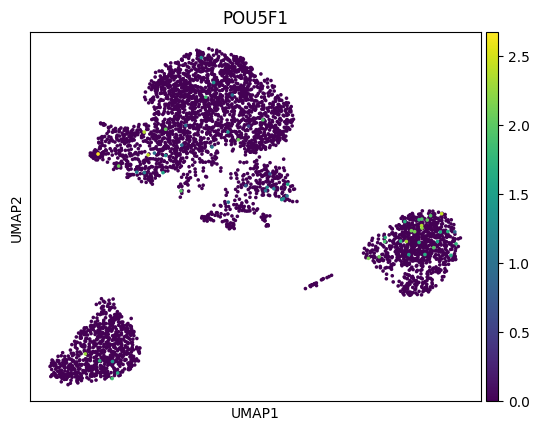

In [118]:
sc.pl.umap(adata_fil, color = "PROM1")
sc.pl.umap(adata_fil, color = "PAX6")#神経幹細胞の自己複製を維持
sc.pl.umap(adata_fil, color = "RELN")#移動中の神経細胞の停止をさえる
sc.pl.umap(adata_fil, color = "SOX2")
sc.pl.umap(adata_fil, color = "POU5F1")#OCT4

クラスタリングしてみる

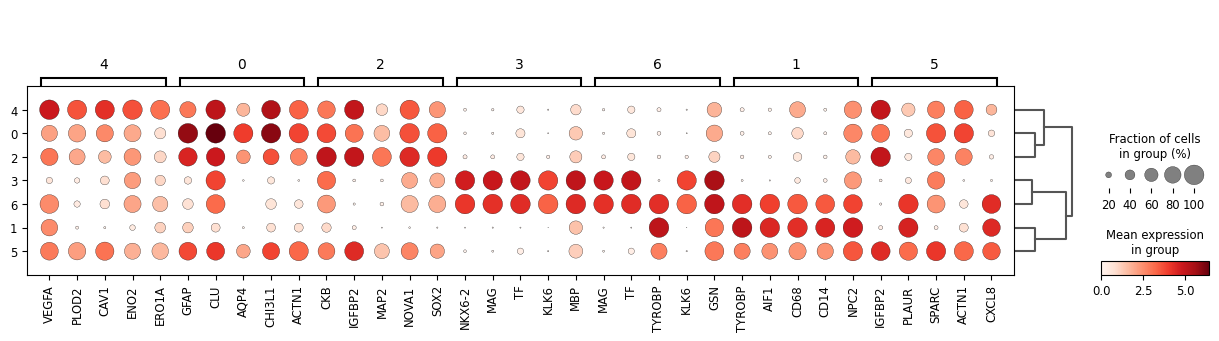

In [141]:
#Leidenクラスタリングを行う、自動的に類似細胞をグループ化してくれる
#グループ名は0, 1, 2とラベル付けされる

#遺伝子名の重複を解消する
adata_fil.var_names_make_unique()

sc.tl.leiden(adata_fil, resolution=0.5)

#マーカー遺伝子の特定
sc.tl.rank_genes_groups(adata_fil, 'leiden', method = 't-test')



#結果をプロット
sc.pl.rank_genes_groups_dotplot(adata_fil, n_genes=5)

各クラスターのトップ５のマーカー遺伝子を表示

---
ドットの大きさ...クラスター内で発言している細胞の割合, 色...遺伝子発現レベル(正規化後の対数発現量)
